In [1]:
import time
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [7]:
#import gym bipedal walker
env = gym.make("BipedalWalker-v3")

## Model structure
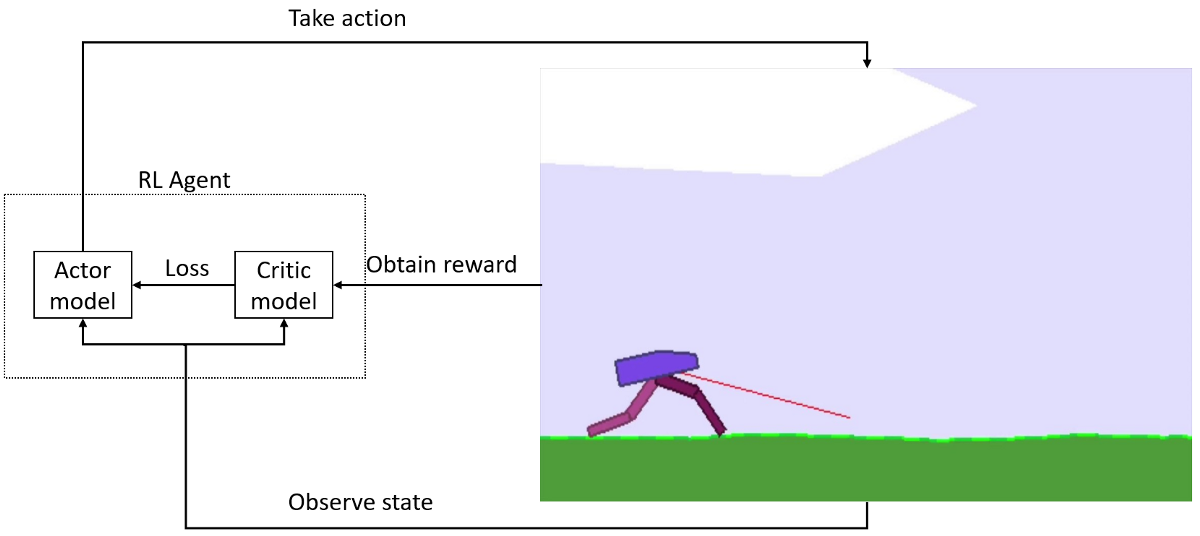

### Testing shnippi implementation
https://github.com/shnippi/GYM/tree/master/TD3

### Plot functions

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os


def simple_plot(scores, mean_scores, epoch):
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    # plt.ylim(ymin=0)
    plt.text(len(scores) - 1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores) - 1, mean_scores[-1], str(mean_scores[-1]))
    if epoch % 10 == 0:
        plt.show()


def plot_learning_curve(x, scores, figure_file, algo, env_id):

    if not os.path.exists('./plots'):
        os.makedirs('./plots')

    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i - 100):(i + 1)])
    plt.plot(x, running_avg)
    plt.title(f'{algo} {env_id} avg 100 scores')
    plt.savefig(figure_file)
    plt.close()

### Agent

In [1]:
import torch as T
import torch.nn.functional as F


In [2]:
import numpy as np

class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

In [3]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from dotenv import load_dotenv

load_dotenv()


class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions,
                 name, chkpt_dir='./models'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + '_td3')

        # I think this breaks if the env has a 2D state representation
        self.fc1 = nn.Linear(self.input_dims[0] + n_actions, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q1 = nn.Linear(self.fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device(os.environ.get('DEVICE') if T.cuda.is_available() else "cpu")

        self.to(self.device)

    def forward(self, state, action):
        # dim = 1 since dim = 0 is the batch dimension
        q1_action_value = self.fc1(T.cat([state, action], dim=1))
        q1_action_value = F.relu(q1_action_value)
        q1_action_value = self.fc2(q1_action_value)
        q1_action_value = F.relu(q1_action_value)

        q1 = self.q1(q1_action_value)

        return q1

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        if not os.path.exists('./models'):
            os.makedirs('./models')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))


class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims,
                 n_actions, name, chkpt_dir='./models'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + '_td3')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device(os.environ.get('DEVICE') if T.cuda.is_available() else "cpu")

        self.to(self.device)

    def forward(self, state):
        prob = self.fc1(state)
        prob = F.relu(prob)
        prob = self.fc2(prob)
        prob = F.relu(prob)

        prob = T.tanh(self.mu(prob))  # if action is > +/- 1 then multiply by max action

        return prob

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        if not os.path.exists('./models'):
            os.makedirs('./models')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

In [4]:
import torch as T
import torch.nn.functional as F
import numpy as np
""" from td3_buffer import ReplayBuffer
from td3_networks import ActorNetwork, CriticNetwork
 """

class Agent():
    def __init__(self, alpha, beta, input_dims, tau, env, env_id,
                 gamma=0.99, update_actor_interval=2, warmup=1000,
                 n_actions=2, max_size=1000000, layer1_size=400,
                 layer2_size=300, batch_size=100, noise=0.1):
        self.algo = "TD3"
        self.gamma = gamma
        self.tau = tau
        self.max_action = env.action_space.high
        self.min_action = env.action_space.low
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.learn_step_cntr = 0
        self.time_step = 0
        self.warmup = warmup
        self.n_actions = n_actions
        self.update_actor_iter = update_actor_interval

        self.actor = ActorNetwork(alpha, input_dims, layer1_size,
                                  layer2_size, n_actions=n_actions,
                                  name=env_id + '_actor')
        self.critic_1 = CriticNetwork(beta, input_dims, layer1_size,
                                      layer2_size, n_actions=n_actions,
                                      name=env_id + '_critic_1')
        self.critic_2 = CriticNetwork(beta, input_dims, layer1_size,
                                      layer2_size, n_actions=n_actions,
                                      name=env_id + '_critic_2')

        self.target_actor = ActorNetwork(alpha, input_dims, layer1_size,
                                         layer2_size, n_actions=n_actions,
                                         name=env_id + '_target_actor')
        self.target_critic_1 = CriticNetwork(beta, input_dims, layer1_size,
                                             layer2_size, n_actions=n_actions,
                                             name=env_id + '_target_critic_1')
        self.target_critic_2 = CriticNetwork(beta, input_dims, layer1_size,
                                             layer2_size, n_actions=n_actions,
                                             name=env_id + '_target_critic_2')

        self.noise = noise
        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        if self.time_step < self.warmup:
            mu = T.tensor(np.random.normal(scale=self.noise, size=(self.n_actions,))).to(self.actor.device)
        else:
            state = T.tensor(observation, dtype=T.float).to(self.actor.device)
            mu = self.actor.forward(state).to(self.actor.device)
        mu_prime = mu + T.tensor(np.random.normal(scale=self.noise),
                                 dtype=T.float).to(self.actor.device)
        mu_prime = T.clamp(mu_prime, self.min_action[0], self.max_action[0]).to(self.actor.device)
        self.time_step += 1
        return mu_prime.cpu().detach().numpy()

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state, done = \
            self.memory.sample_buffer(self.batch_size)

        reward = T.tensor(reward, dtype=T.float).to(self.critic_1.device)
        done = T.tensor(done).to(self.critic_1.device)
        state_ = T.tensor(new_state, dtype=T.float).to(self.critic_1.device)
        state = T.tensor(state, dtype=T.float).to(self.critic_1.device)
        action = T.tensor(action, dtype=T.float).to(self.critic_1.device)

        target_actions = self.target_actor.forward(state_)
        target_actions = target_actions + \
                         T.clamp(T.tensor(np.random.normal(scale=0.2)), -0.5, 0.5)
        # might break if elements of min and max are not all equal
        target_actions = T.clamp(target_actions, self.min_action[0], self.max_action[0])

        q1_ = self.target_critic_1.forward(state_, target_actions)
        q2_ = self.target_critic_2.forward(state_, target_actions)

        q1 = self.critic_1.forward(state, action)
        q2 = self.critic_2.forward(state, action)

        q1_[done] = 0.0
        q2_[done] = 0.0

        q1_ = q1_.view(-1)
        q2_ = q2_.view(-1)

        critic_value_ = T.min(q1_, q2_)

        target = reward + self.gamma * critic_value_
        target = target.view(self.batch_size, 1)

        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()

        q1_loss = F.mse_loss(target, q1)
        q2_loss = F.mse_loss(target, q2)
        critic_loss = q1_loss + q2_loss
        critic_loss.backward()

        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()

        self.learn_step_cntr += 1

        if self.learn_step_cntr % self.update_actor_iter != 0:
            return

        self.actor.optimizer.zero_grad()
        actor_q1_loss = self.critic_1.forward(state, self.actor.forward(state))
        actor_loss = -T.mean(actor_q1_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_1_params = self.critic_1.named_parameters()
        critic_2_params = self.critic_2.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_1_params = self.target_critic_1.named_parameters()
        target_critic_2_params = self.target_critic_2.named_parameters()

        critic_1_state_dict = dict(critic_1_params)
        critic_2_state_dict = dict(critic_2_params)
        actor_state_dict = dict(actor_params)
        target_actor_state_dict = dict(target_actor_params)
        target_critic_1_state_dict = dict(target_critic_1_params)
        target_critic_2_state_dict = dict(target_critic_2_params)

        for name in critic_1_state_dict:
            critic_1_state_dict[name] = tau * critic_1_state_dict[name].clone() + \
                                        (1 - tau) * target_critic_1_state_dict[name].clone()

        for name in critic_2_state_dict:
            critic_2_state_dict[name] = tau * critic_2_state_dict[name].clone() + \
                                        (1 - tau) * target_critic_2_state_dict[name].clone()

        for name in actor_state_dict:
            actor_state_dict[name] = tau * actor_state_dict[name].clone() + \
                                     (1 - tau) * target_actor_state_dict[name].clone()

        self.target_critic_1.load_state_dict(critic_1_state_dict)
        self.target_critic_2.load_state_dict(critic_2_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.target_critic_1.save_checkpoint()
        self.target_critic_2.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic_1.load_checkpoint()
        self.critic_2.load_checkpoint()
        self.target_critic_1.load_checkpoint()
        self.target_critic_2.load_checkpoint()

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os


def simple_plot(scores, mean_scores, epoch):
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    # plt.ylim(ymin=0)
    plt.text(len(scores) - 1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores) - 1, mean_scores[-1], str(mean_scores[-1]))
    if epoch % 10 == 0:
        plt.show()


def plot_learning_curve(x, scores, figure_file, algo, env_id):

    if not os.path.exists('./plots'):
        os.makedirs('./plots')

    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i - 100):(i + 1)])
    plt.plot(x, running_avg)
    plt.title(f'{algo} {env_id} avg 100 scores')
    plt.savefig(figure_file)
    plt.close()

In [6]:
# THIS IS TD3

import gym
import numpy as np
import torch
from dotenv import load_dotenv
import os

load_dotenv()
print("Using {} device".format(os.environ.get('DEVICE') if torch.cuda.is_available() else "cpu"))

# Hyperparams
n_games = 1000
load_checkpoint = False
iterations = 3

env_id = 'BipedalWalker-v3'
# env_id = 'LunarLanderContinuous-v2'

env = gym.make(env_id)
agent = Agent(alpha=0.001, beta=0.001,
              input_dims=env.observation_space.shape, tau=0.005,
              env=env, env_id=env_id, batch_size=100, layer1_size=400, layer2_size=300,
              n_actions=env.action_space.shape[0])


def train(iteration):
    filename = agent.algo + "_" + env_id + "_" + str(n_games) + "games" + "_" + str(iteration) + '.png'
    figure_file = 'plots/' + filename

    best_score = env.reward_range[0]
    score_history = []

    if load_checkpoint:
        agent.load_models()
        if os.environ.get('RENDER') == "t":
            env.render(mode='human')

    steps = 0
    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0

        # for every episode:
        while not done:
            if os.environ.get('RENDER') == "t":
                env.render()

            action = agent.choose_action(observation)
            env.step(action)
            observation_, reward, done, info, a = env.step(action)
            steps += 1
            agent.remember(observation, action, reward, observation_, done)
            if not load_checkpoint:
                agent.learn()
            score += reward
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print(env_id, "|", 'episode', i, "|", 'score %.1f' % score, "|",
              '100 games avg %.1f' % avg_score, "|",
              'steps %d' % steps, "|"
              )

    if not load_checkpoint:
        x = [i + 1 for i in range(n_games)]
        plot_learning_curve(x, score_history, figure_file, agent.algo, env_id)


if __name__ == '__main__':
    for iteration in range(iterations):
        agent = Agent(alpha=0.001, beta=0.001,
                      input_dims=env.observation_space.shape, tau=0.005,
                      env=env, env_id=env_id, batch_size=100, layer1_size=400, layer2_size=300,
                      n_actions=env.action_space.shape[0])
        train(iteration + 1)

Using cpu device


/var/folders/18/27kk04gn68z8t3bc0npl90x00000gn/T/ipykernel_50770/1690095211.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.